# Stacking (Stacked Generalization): The Expert Committee

**Core Concept:** If Bagging is "Democracy" (Majority Vote), and Boosting is "Self-Improvement", then Stacking is **"Teamwork"**.

We gather diverse experts (Base Models) and hire a Manager (Meta Model) to make the final decision based on their opinions.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle
from matplotlib.lines import Line2D
from ipywidgets import interact, IntSlider, Dropdown, Button, VBox, HBox, Output
from IPython.display import display, clear_output
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import clone
import io
from contextlib import redirect_stdout

# Import custom library
import sys
import os
sys.path.append(os.getcwd())

try:
    from MyML import (
        MyStackingClassifier,
        MyKNNClassifier,
        MyDecisionTreeClassifier,
        MyLinearSVM,
        MyLogisticRegression
    )
    print("SUCCESS: MyML Custom Library Loaded!")
except ImportError as e:
    print("ERROR: Could not load MyML.")
    print(f"Details: {e}")

# Visualization Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

SUCCESS: MyML Custom Library Loaded!


## Part 1: Prepare Data

We'll use a challenging 2D dataset to visualize how different models see the problem differently.

Data Ready: 210 training samples, 90 test samples.
Classes: [0 1]


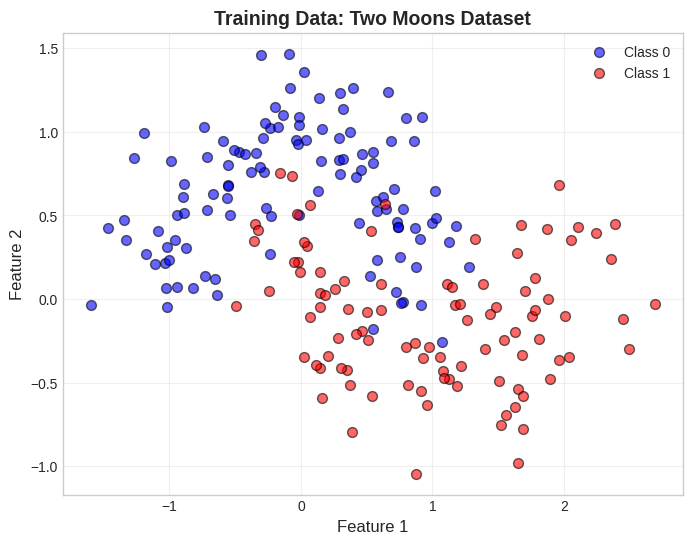

In [12]:
# Generate challenging dataset
X, y = make_moons(n_samples=300, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Data Ready: {len(X_train)} training samples, {len(X_test)} test samples.")
print(f"Classes: {np.unique(y)}")

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
            c='blue', label='Class 0', alpha=0.6, s=50, edgecolors='k')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
            c='red', label='Class 1', alpha=0.6, s=50, edgecolors='k')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Training Data: Two Moons Dataset', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part 2: Train Individual Base Models

Let's see how each "expert" performs individually.

In [13]:
# Define and train base models
base_models = {
    'Decision Tree': MyDecisionTreeClassifier(max_depth=5),
    'KNN (k=7)': MyKNNClassifier(k=7),
    'Linear SVM': MyLinearSVM(learning_rate=0.01, n_iters=1000)
}

# Train each model
trained_models = {}
base_predictions = {}
base_accuracies = {}

print("Training base models...\n")
for name, model in base_models.items():
    print(f"Training {name}...")
    model_copy = clone(model)
    model_copy.fit(X_train, y_train)
    
    y_pred = model_copy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    trained_models[name] = model_copy
    base_predictions[name] = y_pred
    base_accuracies[name] = acc
    
    print(f"  -> Test Accuracy: {acc:.4f}")

print("\nBase models trained successfully!")

Training base models...

Training Decision Tree...
  -> Test Accuracy: 0.8778
Training KNN (k=7)...
  -> Test Accuracy: 0.9444
Training Linear SVM...
  -> Test Accuracy: 0.8889

Base models trained successfully!


## Part 3: Visualize Base Model Decision Boundaries

This is where the magic happens - each model sees the problem differently!

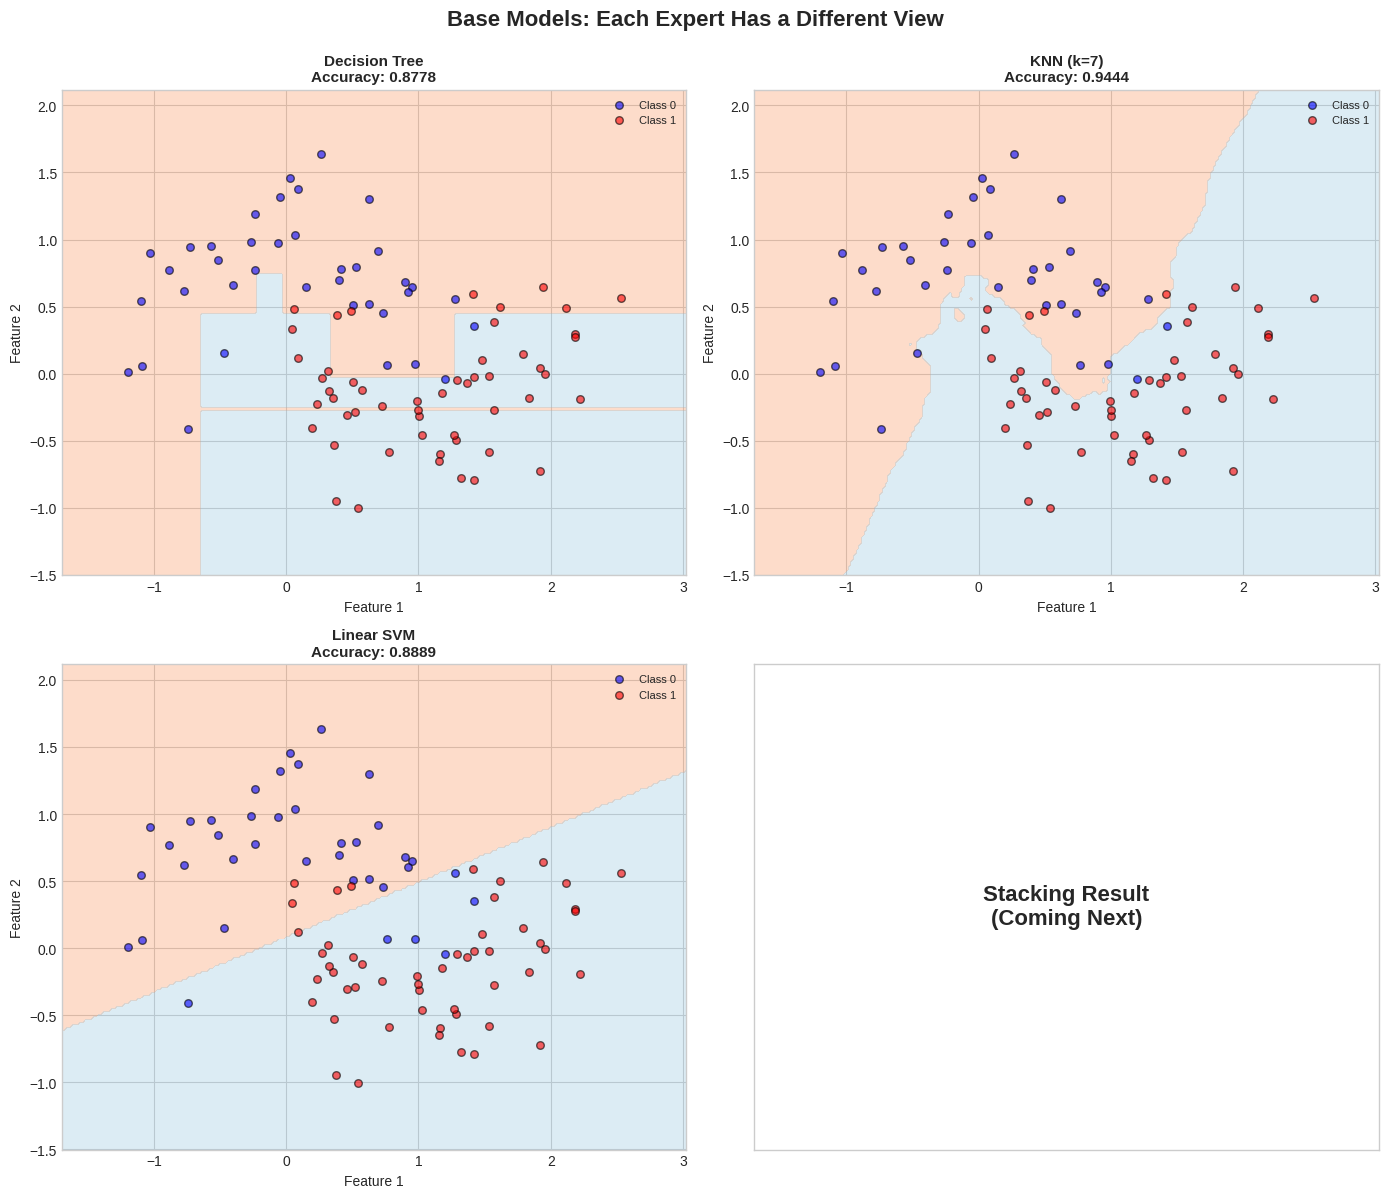


KEY OBSERVATION:
Each model creates a different decision boundary.
Stacking will learn how to combine these diverse perspectives!


In [14]:
def plot_decision_boundary(model, X, y, title, ax):
    """Plot decision boundary for a trained model."""
    h = 0.02  # step size in mesh
    
    # Create mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', 
               label='Class 0', alpha=0.6, s=30, edgecolors='k')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', 
               label='Class 1', alpha=0.6, s=30, edgecolors='k')
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right', fontsize=8)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot each base model
for idx, (name, model) in enumerate(trained_models.items()):
    row = idx // 2
    col = idx % 2
    plot_decision_boundary(
        model, X_test, y_test, 
        f"{name}\nAccuracy: {base_accuracies[name]:.4f}",
        axes[row, col]
    )

# Leave last subplot for later (stacking result)
axes[1, 1].text(0.5, 0.5, 'Stacking Result\n(Coming Next)', 
                ha='center', va='center', fontsize=16, fontweight='bold',
                transform=axes[1, 1].transAxes)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

plt.suptitle('Base Models: Each Expert Has a Different View', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nKEY OBSERVATION:")
print("Each model creates a different decision boundary.")
print("Stacking will learn how to combine these diverse perspectives!")

## Part 4: Interactive Prediction Comparison

Let's examine specific test samples and see how each base model votes.

In [15]:
def visualize_sample_prediction(sample_idx):
    """Visualize how different models predict a specific sample."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: Show sample in context
    axes[0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], 
                    c='blue', alpha=0.3, s=30, label='Class 0')
    axes[0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], 
                    c='red', alpha=0.3, s=30, label='Class 1')
    
    # Highlight selected sample
    sample = X_test[sample_idx]
    true_label = y_test[sample_idx]
    axes[0].scatter(sample[0], sample[1], 
                    c='yellow', s=300, marker='*', 
                    edgecolors='black', linewidths=2,
                    label=f'Selected Sample (True: {true_label})', zorder=10)
    
    axes[0].set_xlabel('Feature 1', fontsize=12)
    axes[0].set_ylabel('Feature 2', fontsize=12)
    axes[0].set_title('Sample Location', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right plot: Show predictions
    model_names = list(trained_models.keys())
    predictions = [model.predict(sample.reshape(1, -1))[0] for model in trained_models.values()]
    
    colors_pred = ['green' if pred == true_label else 'red' for pred in predictions]
    
    bars = axes[1].barh(model_names, predictions, color=colors_pred, alpha=0.7)
    axes[1].axvline(x=true_label, color='blue', linestyle='--', linewidth=2, 
                    label=f'True Label: {true_label}')
    
    # Add prediction labels
    for i, (bar, pred) in enumerate(zip(bars, predictions)):
        axes[1].text(pred + 0.05, i, f'Class {int(pred)}', 
                    va='center', fontweight='bold')
    
    axes[1].set_xlabel('Predicted Class', fontsize=12)
    axes[1].set_title(f'Base Model Predictions\n(Sample #{sample_idx})', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlim([-0.3, 1.3])
    axes[1].set_xticks([0, 1])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSample #{sample_idx} Analysis:")
    print(f"  True Label: {true_label}")
    print(f"  Feature Values: [{sample[0]:.3f}, {sample[1]:.3f}]")
    print(f"\n  Base Model Predictions:")
    for name, pred in zip(model_names, predictions):
        status = "CORRECT" if pred == true_label else "WRONG"
        print(f"    {name:<20}: Class {int(pred)} ({status})")
    
    # Majority vote
    majority = int(np.round(np.mean(predictions)))
    print(f"\n  Majority Vote: Class {majority}")
    print(f"  Agreement: {sum(p == majority for p in predictions)}/{len(predictions)} models")

# Create interactive widget
print("\nSELECT A TEST SAMPLE to see how each model votes:\n")
interact(visualize_sample_prediction, 
         sample_idx=IntSlider(min=0, max=len(X_test)-1, step=1, value=5,
                             description='Sample ID:'));


SELECT A TEST SAMPLE to see how each model votes:



interactive(children=(IntSlider(value=5, description='Sample ID:', max=89), Output()), _dom_classes=('widget-i…

## Part 5: Visualize Meta-Features

The meta-model doesn't see the original features - it sees the BASE MODEL PREDICTIONS as features!

META-FEATURES (Base Model Predictions):
Sample     Tree       KNN        SVM        True Label  
----------------------------------------------------------------------
0          1          1          1          1           
1          0          1          1          1           
2          1          1          1          1           
3          1          1          1          1           
4          1          1          1          1           
5          1          0          0          0           
6          0          1          1          1           
7          0          0          0          0           
8          1          1          1          1           
9          1          1          1          1           
...

These predictions become INPUT for the meta-model!



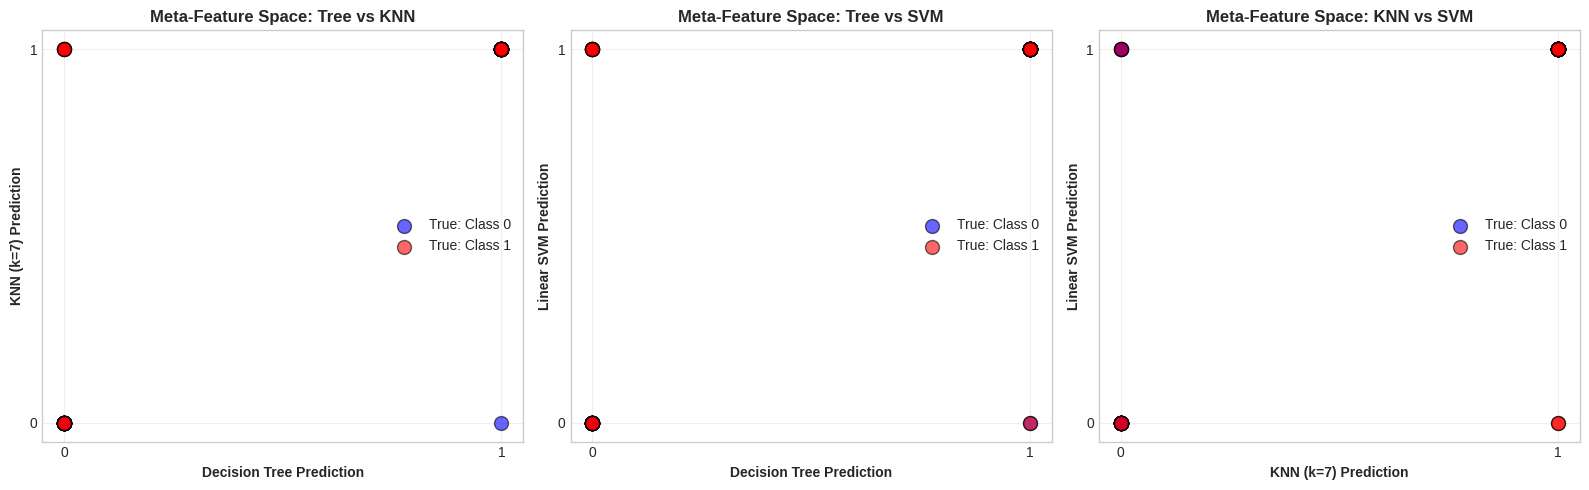


KEY INSIGHT:
The meta-model learns patterns in these predictions.
For example: 'If Tree=1 and KNN=1 but SVM=0, trust Tree and KNN more.'


In [16]:
# Get base model predictions for test set (these become meta-features)
meta_features = np.column_stack([model.predict(X_test) for model in trained_models.values()])

print("META-FEATURES (Base Model Predictions):")
print("="*70)
print(f"{'Sample':<10} {'Tree':<10} {'KNN':<10} {'SVM':<10} {'True Label':<12}")
print("-"*70)
for i in range(min(10, len(meta_features))):
    print(f"{i:<10} {int(meta_features[i,0]):<10} {int(meta_features[i,1]):<10} "
          f"{int(meta_features[i,2]):<10} {y_test[i]:<12}")
print("...")
print("\nThese predictions become INPUT for the meta-model!\n")

# Visualize meta-feature space
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_names = list(trained_models.keys())

# Plot 1: Tree vs KNN
axes[0].scatter(meta_features[y_test==0, 0], meta_features[y_test==0, 1],
               c='blue', alpha=0.6, s=100, label='True: Class 0', edgecolors='k')
axes[0].scatter(meta_features[y_test==1, 0], meta_features[y_test==1, 1],
               c='red', alpha=0.6, s=100, label='True: Class 1', edgecolors='k')
axes[0].set_xlabel(f'{model_names[0]} Prediction', fontweight='bold')
axes[0].set_ylabel(f'{model_names[1]} Prediction', fontweight='bold')
axes[0].set_title('Meta-Feature Space: Tree vs KNN', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])

# Plot 2: Tree vs SVM
axes[1].scatter(meta_features[y_test==0, 0], meta_features[y_test==0, 2],
               c='blue', alpha=0.6, s=100, label='True: Class 0', edgecolors='k')
axes[1].scatter(meta_features[y_test==1, 0], meta_features[y_test==1, 2],
               c='red', alpha=0.6, s=100, label='True: Class 1', edgecolors='k')
axes[1].set_xlabel(f'{model_names[0]} Prediction', fontweight='bold')
axes[1].set_ylabel(f'{model_names[2]} Prediction', fontweight='bold')
axes[1].set_title('Meta-Feature Space: Tree vs SVM', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])

# Plot 3: KNN vs SVM
axes[2].scatter(meta_features[y_test==0, 1], meta_features[y_test==0, 2],
               c='blue', alpha=0.6, s=100, label='True: Class 0', edgecolors='k')
axes[2].scatter(meta_features[y_test==1, 1], meta_features[y_test==1, 2],
               c='red', alpha=0.6, s=100, label='True: Class 1', edgecolors='k')
axes[2].set_xlabel(f'{model_names[1]} Prediction', fontweight='bold')
axes[2].set_ylabel(f'{model_names[2]} Prediction', fontweight='bold')
axes[2].set_title('Meta-Feature Space: KNN vs SVM', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("The meta-model learns patterns in these predictions.")
print("For example: 'If Tree=1 and KNN=1 but SVM=0, trust Tree and KNN more.'")

## Part 6: Train Stacking Model

Now let's combine everything with a meta-learner!

In [17]:
# Define base estimators for stacking
base_estimators = [
    ('tree', MyDecisionTreeClassifier(max_depth=5)),
    ('knn', MyKNNClassifier(k=7)),
    ('svm', MyLinearSVM(learning_rate=0.01, n_iters=1000))
]

# Create stacking classifier
stacking = MyStackingClassifier(
    estimators=base_estimators,
    final_estimator=MyLogisticRegression(learning_rate=0.1),
    blend_ratio=0.5
)

print("Training Stacking Classifier...\n")

# Suppress training output
with redirect_stdout(io.StringIO()):
    stacking.fit(X_train, y_train)

# Evaluate
y_pred_stacking = stacking.predict(X_test)
acc_stacking = accuracy_score(y_test, y_pred_stacking)

print("Stacking trained successfully!\n")
print("PERFORMANCE COMPARISON:")
print("="*60)
print(f"{'Model':<25} {'Test Accuracy':<15}")
print("-"*60)
for name, acc in base_accuracies.items():
    print(f"{name:<25} {acc:.4f}")
print("-"*60)
print(f"{'STACKING (Ensemble)':<25} {acc_stacking:.4f}")
print("="*60)

improvement = (acc_stacking - max(base_accuracies.values())) * 100
print(f"\nImprovement over best base model: {improvement:+.2f}%")

Training Stacking Classifier...



Stacking trained successfully!

PERFORMANCE COMPARISON:
Model                     Test Accuracy  
------------------------------------------------------------
Decision Tree             0.8778
KNN (k=7)                 0.9444
Linear SVM                0.8889
------------------------------------------------------------
STACKING (Ensemble)       0.9333

Improvement over best base model: -1.11%


## Part 7: Visualize Stacking Decision Boundary

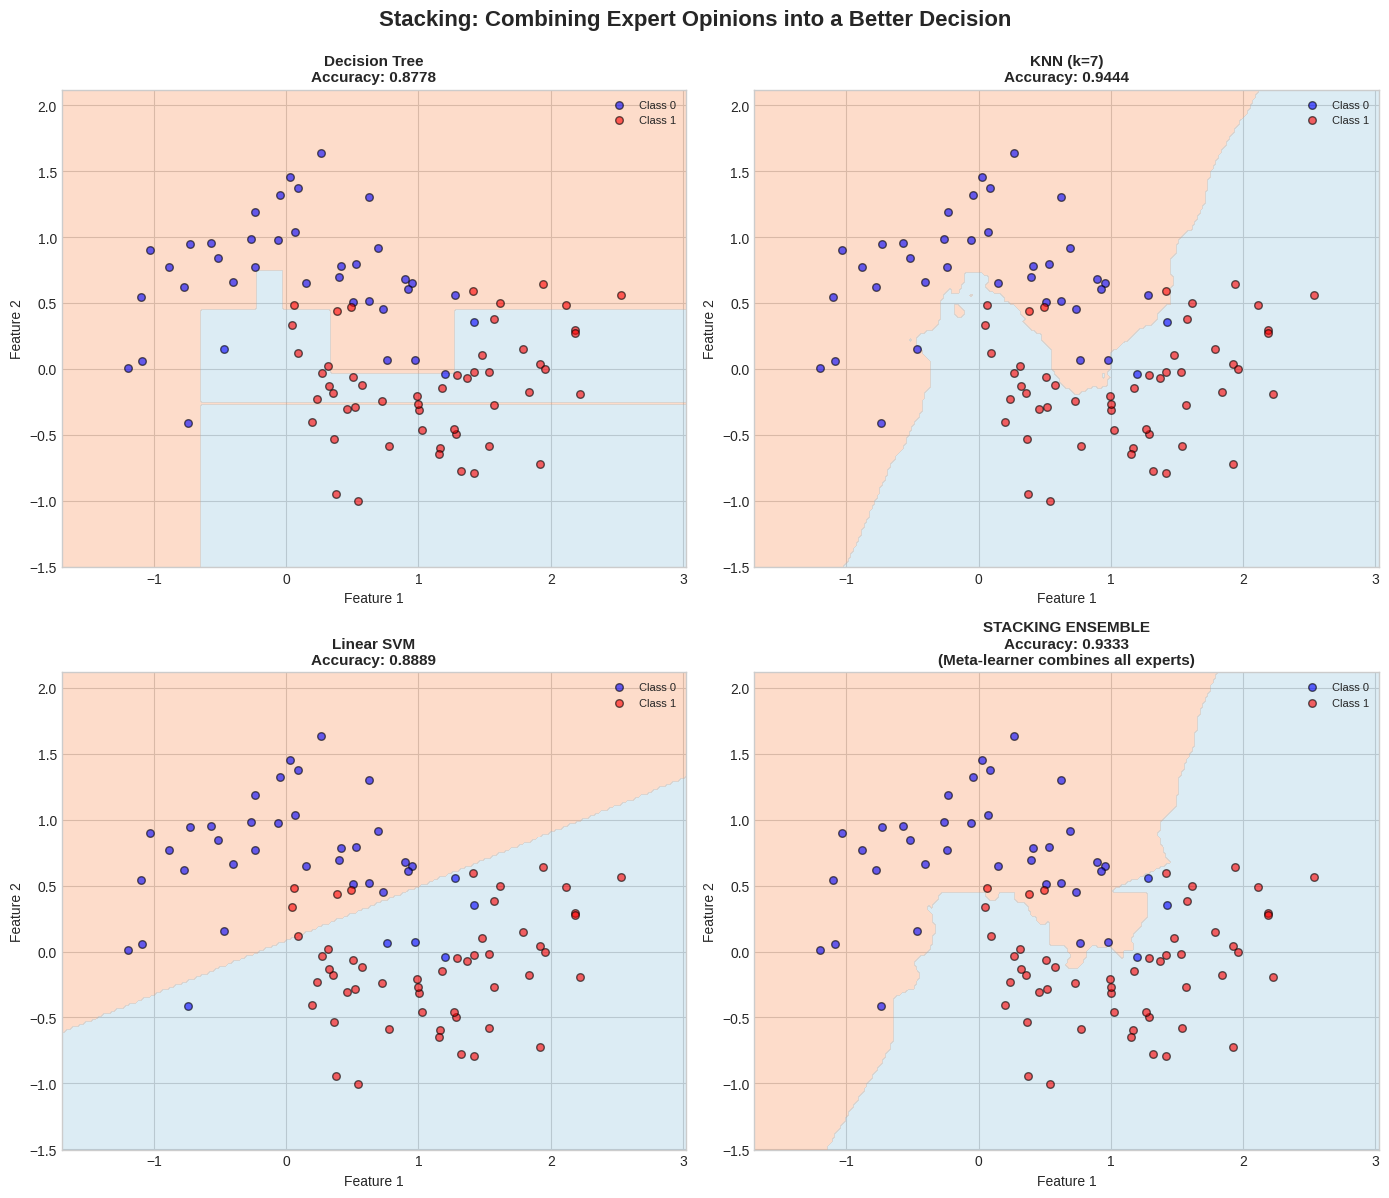


NOTICE:
The stacking boundary is smoother and more accurate than individual models.
The meta-learner learned which expert to trust in different regions!


In [18]:
# Create comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot base models
for idx, (name, model) in enumerate(trained_models.items()):
    row = idx // 2
    col = idx % 2
    plot_decision_boundary(
        model, X_test, y_test, 
        f"{name}\nAccuracy: {base_accuracies[name]:.4f}",
        axes[row, col]
    )

# Plot stacking result
plot_decision_boundary(
    stacking, X_test, y_test,
    f"STACKING ENSEMBLE\nAccuracy: {acc_stacking:.4f}\n(Meta-learner combines all experts)",
    axes[1, 1]
)

plt.suptitle('Stacking: Combining Expert Opinions into a Better Decision', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nNOTICE:")
print("The stacking boundary is smoother and more accurate than individual models.")
print("The meta-learner learned which expert to trust in different regions!")

## Part 8: Error Analysis - Who Gets What Wrong?

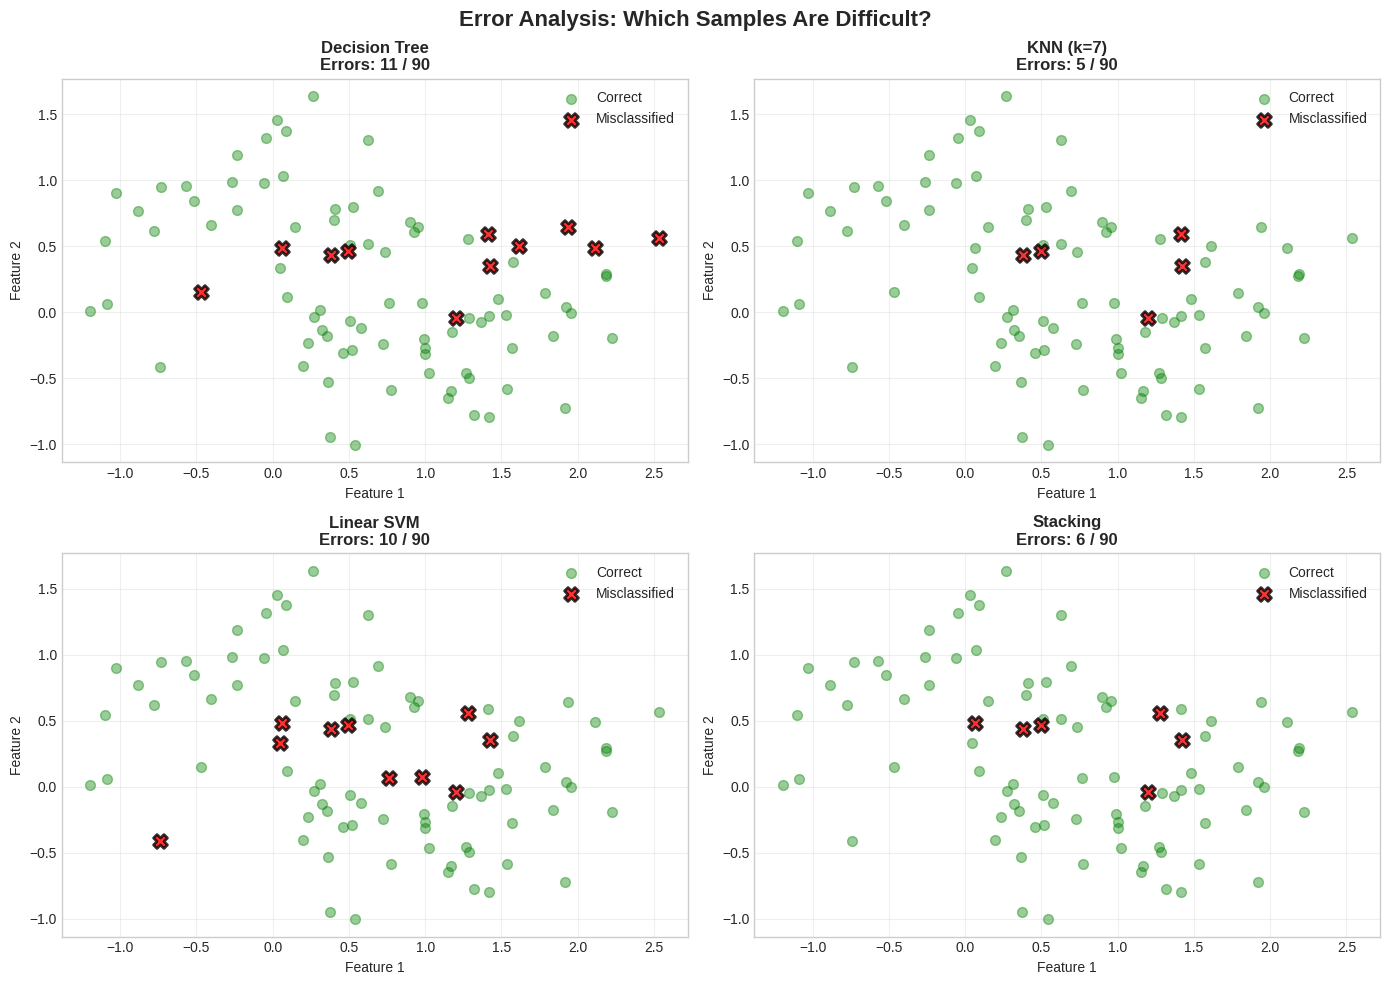


ERROR STATISTICS:
Model                     Errors     Error Rate     
------------------------------------------------------------
Decision Tree             11         12.22%
KNN (k=7)                 5          5.56%
Linear SVM                10         11.11%
Stacking                  6          6.67%


In [19]:
# Find misclassified samples for each model
misclassified = {}
for name, model in trained_models.items():
    preds = model.predict(X_test)
    misclassified[name] = np.where(preds != y_test)[0]

# Stacking misclassifications
misclassified['Stacking'] = np.where(y_pred_stacking != y_test)[0]

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Error Analysis: Which Samples Are Difficult?', 
             fontsize=16, fontweight='bold')

all_models = list(trained_models.keys()) + ['Stacking']

for idx, name in enumerate(all_models):
    row = idx // 2
    col = idx % 2
    
    # Plot correctly classified (green)
    correct_idx = np.setdiff1d(np.arange(len(X_test)), misclassified[name])
    axes[row, col].scatter(X_test[correct_idx, 0], X_test[correct_idx, 1],
                          c='green', alpha=0.4, s=50, label='Correct')
    
    # Plot misclassified (red)
    if len(misclassified[name]) > 0:
        axes[row, col].scatter(X_test[misclassified[name], 0], 
                              X_test[misclassified[name], 1],
                              c='red', alpha=0.8, s=100, 
                              marker='X', edgecolors='black', linewidths=2,
                              label='Misclassified')
    
    axes[row, col].set_xlabel('Feature 1')
    axes[row, col].set_ylabel('Feature 2')
    axes[row, col].set_title(f"{name}\nErrors: {len(misclassified[name])} / {len(y_test)}",
                            fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print("\nERROR STATISTICS:")
print("="*60)
print(f"{'Model':<25} {'Errors':<10} {'Error Rate':<15}")
print("-"*60)
for name in all_models:
    n_errors = len(misclassified[name])
    error_rate = n_errors / len(y_test) * 100
    print(f"{name:<25} {n_errors:<10} {error_rate:.2f}%")
print("="*60)

# Find samples that ALL base models get wrong but stacking gets right
all_base_wrong = set(misclassified['Decision Tree']) & \
                 set(misclassified['KNN (k=7)']) & \
                 set(misclassified['Linear SVM'])
stacking_right = set(np.setdiff1d(np.arange(len(X_test)), misclassified['Stacking']))
rescued = all_base_wrong & stacking_right


## Part 9: Interactive Meta-Learner Selection

Try different meta-learners and see how performance changes!

In [ ]:
def compare_meta_learners(meta_model_name):
    """Train stacking with different meta-learners and compare."""
    
    # Select meta model
    if meta_model_name == 'Logistic Regression (Standard)':
        meta = MyLogisticRegression(learning_rate=0.1)
        meta_desc = "Linear combination of base predictions"
    elif meta_model_name == 'Decision Tree (Non-linear)':
        meta = MyDecisionTreeClassifier(max_depth=3)
        meta_desc = "Learns complex rules from base predictions"
    elif meta_model_name == 'KNN (Similarity-based)':
        meta = MyKNNClassifier(k=5)
        meta_desc = "Finds similar prediction patterns"
    
    # Train stacking
    stack = MyStackingClassifier(
        estimators=base_estimators,
        final_estimator=meta,
        blend_ratio=0.5
    )
    
    with redirect_stdout(io.StringIO()):
        stack.fit(X_train, y_train)
    
    # Evaluate
    y_pred = stack.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Decision boundary
    plot_decision_boundary(stack, X_test, y_test,
                          f"Stacking with {meta_model_name}\nAccuracy: {acc:.4f}",
                          axes[0])
    
    # Right: Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix\n{meta_desc}", fontweight='bold')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    print(f"\nMeta-Learner: {meta_model_name}")
    print(f"Description: {meta_desc}")
    print(f"Accuracy: {acc:.4f}")
    print(f"\nComparison with base models:")
    for name, base_acc in base_accuracies.items():
        diff = (acc - base_acc) * 100
        print(f"  vs {name}: {diff:+.2f}%")

# Create interactive dropdown
print("\nTry different META-LEARNERS:\n")
interact(compare_meta_learners,
         meta_model_name=Dropdown(
             options=['Logistic Regression (Standard)', 
                     'Decision Tree (Non-linear)', 
                     'KNN (Similarity-based)'],
             value='Logistic Regression (Standard)',
             description='Meta Model:'
         ));


Try different META-LEARNERS:



interactive(children=(Dropdown(description='Meta Model:', options=('Logistic Regression (Standard)', 'Decision…

## Summary
1. **Base Models are Diverse**
   - Each model sees the problem differently
   - Different decision boundaries capture different patterns

2. **Meta-Features are Predictions**
   - The meta-learner doesn't see original features
   - It sees base model predictions as input
   - Learns which expert to trust when

3. **Stacking Advantages**
   - Combines strengths of diverse models
   - Can correct errors that all base models make
   - Usually outperforms individual models

4. **Meta-Learner Selection Matters**
   - Linear meta-learner: Simple weighted combination
   - Non-linear meta-learner: Complex decision rules
   - Logistic Regression is most common choice

### When to Use Stacking:

- You have diverse models with different strengths
- Want maximum performance (competitions)
- Have enough data for two-stage training
- Computational cost is acceptable

### Limitations:

- More complex than Bagging/Boosting
- Risk of overfitting if not enough data
- Harder to interpret
- Slowest training time among ensemble methods